## Training results
- Machine Learning; predicting cost: MAE 5.2
- Machine Learning; predicting total_secs + num_unq: MAE 5.2

- Deep Learning; predicting cost: MAE 5.1
- Deep Learning; predicting total_secs + num_unq: MAE ?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Utils.DataLoader import DataLoader
from Utils.DataTransformer import DataTransformer
from Utils.DuckDb import DuckDb
from datetime import datetime
import pandas as pd
from typing import List
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from Utils import PandasNotebookConfigs

# Importing all the tools we need

# Regular EDA (Exploratory Data Analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# If matplotlib plots don't work, uncomment this line
# %matplotlib inline

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, RocCurveDisplay

In [3]:
PandasNotebookConfigs.config()

Ajustando display.float.format para %.2f


In [4]:
DUCK_DB_UTILS = DuckDb()
DATA_TRANSFORMER = DataTransformer()

In [60]:
TABLE_NAME = 'treated_churn_dataset_2025_03_11_08h03m'
TABLE_NAME = 'treated_churn_dataset_2025_03_11_15h03m'
TABLE_NAME = 'treated_churn_dataset_2025_03_11_19h03m'

In [61]:
df = DUCK_DB_UTILS.load_table(TABLE_NAME)

In [62]:
len(df)

768737

In [63]:
# Treating DF
df.isna().sum().T

cost                                  0
msno                                  0
safra                                 0
num_25                                0
num_50                                0
num_75                                0
num_985                               0
num_100                               0
num_unq                               0
total_secs                            0
total_hours                           0
msno_1                                0
payment_method_id                     0
payment_plan_days                     0
plan_list_price                       0
actual_amount_paid                    0
is_auto_renew                         0
is_cancel                             0
safra_1                               0
transaction_date_year                 0
transaction_date_month                0
transaction_date_day                  0
transaction_date_day_of_week          0
transaction_date_day_of_year          0
membership_expire_date_year           0


In [64]:
df = df[df['should_delete_row'] == False]
df = df.drop('should_delete_row', axis=1)

In [65]:
df.head()

,cost,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,...,safra_2,city,registered_via,is_active,registration_init_time_year,registration_init_time_month,registration_init_time_day,registration_init_time_day_of_week,registration_init_time_day_of_year,is_churn
4,64.67,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201607,72,17,17,17,459,513,120546,...,201607,15,9,True,2010,11,18,3,322,False
5,72.33,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201608,77,27,35,29,709,747,185178,...,201608,15,9,True,2010,11,18,3,322,False
6,70.95,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201609,53,28,18,19,665,707,173410,...,201609,15,9,True,2010,11,18,3,322,False
10,76.04,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,201601,113,48,33,45,774,845,217292,...,201601,1,7,True,2014,9,27,5,270,False
11,70.49,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,201602,284,89,53,55,534,840,162097,...,201602,1,7,True,2014,9,27,5,270,False


In [66]:
# Feature engineering
df['safra_year'] = df['safra'].astype(str).str[:4].astype(float)
df['safra_month'] = df['safra'].astype(str).str[-2:].astype(float)

In [67]:
df.head()

,cost,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,...,registered_via,is_active,registration_init_time_year,registration_init_time_month,registration_init_time_day,registration_init_time_day_of_week,registration_init_time_day_of_year,is_churn,safra_year,safra_month
4,64.67,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201607,72,17,17,17,459,513,120546,...,9,True,2010,11,18,3,322,False,2016.00,7.00
5,72.33,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201608,77,27,35,29,709,747,185178,...,9,True,2010,11,18,3,322,False,2016.00,8.00
6,70.95,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,201609,53,28,18,19,665,707,173410,...,9,True,2010,11,18,3,322,False,2016.00,9.00
10,76.04,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,201601,113,48,33,45,774,845,217292,...,7,True,2014,9,27,5,270,False,2016.00,1.00
11,70.49,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,201602,284,89,53,55,534,840,162097,...,7,True,2014,9,27,5,270,False,2016.00,2.00


In [68]:
    # # Selecting features after Lasso
    # lasso_selected_features = [
    #     # X features
    #     'cost', 'safra', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100',
    #     'num_unq', 'total_secs', 'payment_method_id', 'payment_plan_days', 'plan_list_price',
    #     'is_auto_renew', 'transaction_date_month', 'transaction_date_day', 'transaction_date_day_of_week',
    #     'transaction_date_day_of_year', 'membership_expire_date_month', 'membership_expire_date_day',
    #     'membership_expire_date_day_of_week', 'membership_expire_date_day_of_year', 'discount', 'price_per_month',
    #     'city', 'registered_via', 'registration_init_time_year', 'registration_init_time_month',
    #     'registration_init_time_day', 'registration_init_time_day_of_week', 'registration_init_time_day_of_year',
    #     'cost-2M', 'cost-1M', 'num_unq-2M', 'num_unq-1M', 'total_secs-2M', 'total_secs-1M',

    #     # y targets
    #     'total_secs+1M', 'num_unq+1M', 'cost+1M'
    # ]

    # df = df[lasso_selected_features]

In [69]:
df.isna().sum().T

cost                                  0
msno                                  0
safra                                 0
num_25                                0
num_50                                0
num_75                                0
num_985                               0
num_100                               0
num_unq                               0
total_secs                            0
total_hours                           0
msno_1                                0
payment_method_id                     0
payment_plan_days                     0
plan_list_price                       0
actual_amount_paid                    0
is_auto_renew                         0
is_cancel                             0
safra_1                               0
transaction_date_year                 0
transaction_date_month                0
transaction_date_day                  0
transaction_date_day_of_week          0
transaction_date_day_of_year          0
membership_expire_date_year           0


In [70]:
# Dropping duplicated columns or useless columns
drop_columns = ['msno', 'safra_1', 'safra_2', 'msno_1', 'msno_2']
for col in drop_columns:
    if col not in df.columns:
        print(f'Coluna {col} não existente no DataFrame')
    else:
        print(f'Dropando coluna {col}')
        df = df.drop(col, axis=1,)

Dropando coluna msno
Dropando coluna safra_1
Dropando coluna safra_2
Dropando coluna msno_1
Dropando coluna msno_2


In [71]:
df.head().T

,4,5,6,10,11
cost,64.67,72.33,70.95,76.04,70.49
safra,201607,201608,201609,201601,201602
num_25,72,77,53,113,284
num_50,17,27,28,48,89
num_75,17,35,18,33,53
num_985,17,29,19,45,55
num_100,459,709,665,774,534
num_unq,513,747,707,845,840
total_secs,120546,185178,173410,217292,162097
total_hours,33.48,51.44,48.17,60.36,45.03


In [72]:
# Turning columns into categories
cat_columns = [
    'payment_method_id',
    'city',
    'registered_via',
]

df = DATA_TRANSFORMER.convert_to_category(
    df,
    cat_columns
)

df = pd.get_dummies(df, columns=cat_columns)

In [73]:
df.dtypes

cost                 float64
safra                  int64
num_25                 int64
num_50                 int64
num_75                 int64
                      ...   
registered_via_13       bool
registered_via_3        bool
registered_via_4        bool
registered_via_7        bool
registered_via_9        bool
Length: 89, dtype: object

In [90]:
target_cols = 'is_churn'

true_df = df[df['is_churn'] == True]
false_df = df[df['is_churn'] == False]

false_df = false_df[:len(true_df)]

new_df = pd.concat([true_df, false_df])

X = df.drop(target_cols, axis=1)
y = df[target_cols]

X = new_df.drop(target_cols, axis=1)
y = new_df[target_cols]

# target_cols = ['total_secs+1M', 'num_unq+1M']
# X = df.drop(target_cols, axis=1)
# y = df[target_cols]

In [95]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=7)
# X = pca.fit_transform(X)

In [96]:
len(X), len(y)

(52862, 52862)

In [97]:
y[y == True], y[y == False]

(100       True
 173       True
 174       True
 244       True
 245       True
           ... 
 768559    True
 768571    True
 768572    True
 768573    True
 768645    True
 Name: is_churn, Length: 26431, dtype: bool,
 4        False
 5        False
 6        False
 10       False
 11       False
          ...  
 50884    False
 50885    False
 50886    False
 50887    False
 50893    False
 Name: is_churn, Length: 26431, dtype: bool)

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcular os pesos das classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))
class_weight_dict

{False: 1.0, True: 1.0}

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train_cost = X_train['cost+1M']
# X_train = X_train.drop('cost+1M', axis=1)

# X_test_cost = X_test['cost+1M']
# X_test = X_test.drop('cost+1M', axis=1)

In [100]:
len(X_train), len(X_test), len(y_train), len(y_test)

(42289, 10573, 42289, 10573)

In [101]:
# model = RandomForestRegressor(
#     n_jobs=-1,
#     random_state=42,
# )

# model.fit(X_train, y_train)

In [102]:
# Create evaluation function (the competition uses RMLSE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score, mean_squared_error
import numpy as np


def rmsle(y_test, y_preds):
    '''
    Calculates root mean squared error between predictions and true labels
    '''
    return str(np.sqrt(mean_squared_log_error(y_test, y_preds)))


def show_scores(model, X_train, X_test, y_train, y_test):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_test)

    # When val_preds score is bigger, it means that your model has overfitting problems
    scores = {
        'Training MAE': mean_absolute_error(y_train, train_preds),
        'Valid MAE': mean_absolute_error(y_test, val_preds),

        # 'Training RMSLE': rmsle(y_train, train_preds),
        # 'Valid RMSLE': rmsle(y_test, val_preds),

        'Training R^2': r2_score(y_train, train_preds),
        'Valid R^2': r2_score(y_test, val_preds),
    }

    return scores


def show_scores_2(y_true, y_preds):
    # When val_preds score is bigger, it means that your model has overfitting problems
    scores = {
        'MAE': mean_absolute_error(y_true, y_preds),
        'MSE': mean_squared_error(y_true, y_preds),
        'R^2': r2_score(y_true, y_preds),
    }

    return scores

In [103]:
X_train.head().T

,244902,344801,110750,44760,311767
cost,55.20,50.26,84.66,58.04,57.77
safra,201603,201608,201605,201605,201608
num_25,21,5,251,298,19
num_50,6,1,52,10,3
num_75,8,0,30,11,6
...,...,...,...,...,...
registered_via_13,False,False,False,False,False
registered_via_3,False,False,False,False,False
registered_via_4,False,False,False,False,False
registered_via_7,False,True,True,True,True


In [104]:
X.head()

,cost,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,total_hours,...,city_5,city_6,city_7,city_8,city_9,registered_via_13,registered_via_3,registered_via_4,registered_via_7,registered_via_9
100,70.03,201601,110,25,30,24,691,638,167782,46.61,...,False,False,False,False,False,False,False,False,True,False
173,64.53,201601,5,1,3,27,462,457,122041,33.90,...,False,False,False,False,False,False,False,False,True,False
174,75.94,201602,7,2,1,3,866,857,215713,59.92,...,False,False,False,False,False,False,False,False,True,False
244,52.24,201605,2,1,1,2,72,77,18474,5.13,...,False,False,False,False,False,False,False,False,True,False
245,52.51,201606,3,1,5,1,77,86,20678,5.74,...,False,False,False,False,False,False,False,False,True,False


In [105]:
X_test.head()

,cost,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,total_hours,...,city_5,city_6,city_7,city_8,city_9,registered_via_13,registered_via_3,registered_via_4,registered_via_7,registered_via_9
30561,63.08,201604,52,26,23,25,370,445,108081,30.02,...,False,False,False,False,False,False,False,False,True,False
17535,62.07,201606,191,27,14,18,352,499,95237,26.45,...,False,False,False,False,False,False,False,False,False,True
757474,65.88,201604,52,19,13,5,617,190,149134,41.43,...,False,False,False,False,False,False,False,False,False,True
479636,50.95,201608,1,0,1,0,30,32,7829,2.17,...,False,False,False,False,False,False,False,False,True,False
580806,95.06,201603,753,204,125,86,1162,1648,366579,101.83,...,False,False,False,False,False,False,False,False,True,False


In [106]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

/home/caio/Git-Projetos/2025-case-data-master-caio-arrabal/env/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [107]:
# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# Put models on a dictionary
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight=class_weight_dict),
    # 'KNN': KNeighborsClassifier(),
    # 'Random Forest': RandomForestClassifier(random_state=42),
    # 'Gradient Boost': GradientBoostingClassifier(random_state=42),
    # 'SVC': SVC(random_state=42),
    # 'MLP': MLPClassifier(random_state=42),
    'XGBClassifier': XGBClassifier(random_state=42),
    'LGBMClassifier': LGBMClassifier(random_state=42),
    'CatBoostClassifier': CatBoostClassifier(random_state=42),
}



# Exemplo de inicialização de alguns classificadores
# xgb = XGBClassifier()
# lgbm = LGBMClassifier()
# catboost = CatBoostClassifier()

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    '''
    Fits and evaluates given machine learning models.
    models: a dict of different Scikit-Learning machine learning models
    X_train: training data, no labels
    X_test: testing data, no labels 
    y_train: training labels
    y_test: test labels
    '''
    np.random.seed(42)

    models_scores = {}
    for name, model in models.items():
        # Fit the model to the data
        print(f'{datetime.now()} Treinando {name}...')
        model.fit(X_train, y_train)
        # model.fit(X_res, y_res)

        # # Evaluate the model and append its score to model_scores
        # models_scores[name] = model.score(X_test, y_test)

        print(f'{datetime.now()} Predict {name}...')
        y_preds = model.predict(X_test)

        # score = recall_score(y_test, y_preds)
        score = f1_score(y_test, y_preds)
        print(f'{datetime.now()} Score (recall): {score}...')
        matrix = confusion_matrix(y_test, y_preds)

        print(matrix)
        print('\n')

        models_scores[name] = score

    return models_scores

In [108]:
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_scores

2025-03-11 22:09:18.823559 Treinando Logistic Regression...


/home/caio/Git-Projetos/2025-case-data-master-caio-arrabal/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2025-03-11 22:09:19.185516 Predict Logistic Regression...
2025-03-11 22:09:19.194219 Score (recall): 0.625383738268573...
[[2737 2605]
 [1666 3565]]


2025-03-11 22:09:19.196055 Treinando XGBClassifier...
2025-03-11 22:09:19.791964 Predict XGBClassifier...
2025-03-11 22:09:19.813159 Score (recall): 0.7674985926064928...
[[4005 1337]
 [1141 4090]]


2025-03-11 22:09:19.814494 Treinando LGBMClassifier...
[LightGBM] [Info] Number of positive: 21200, number of negative: 21089
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3219
[LightGBM] [Info] Number of data points in the train set: 42289, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501312 -> initscore=0.005250
[LightGBM] [Info] Start training from score 0.005250
2025-03-11 22:09:20.068984 Predict LGBMClassifier...
2025-03-11 22:09:20.084419 Score (recall): 0.7503

{'Logistic Regression': 0.625383738268573,
 'XGBClassifier': 0.7674985926064928,
 'LGBMClassifier': 0.750351617440225,
 'CatBoostClassifier': 0.7862081681570942}

2025-03-11 21:09:17.702939 Predict Logistic Regression...
2025-03-11 21:09:17.748032 Score (recall): 0.6285178236397748...
2025-03-11 21:09:17.748071 Treinando KNN...
2025-03-11 21:09:18.006057 Predict KNN...
2025-03-11 21:09:37.052490 Score (recall): 0.33583489681050654...
2025-03-11 21:09:37.052583 Treinando Random Forest...
2025-03-11 21:10:55.966318 Predict Random Forest...
2025-03-11 21:10:57.044439 Score (recall): 0.1651031894934334...
2025-03-11 21:10:57.044607 Treinando Gradient Boost...
2025-03-11 21:13:24.975815 Predict Gradient Boost...
2025-03-11 21:13:25.081741 Score (recall): 0.1719824890556598...
2025-03-11 21:13:25.081786 Treinando SVC...

In [109]:
chosen_model = models['CatBoostClassifier']

[[3990 1352]
 [ 967 4264]]


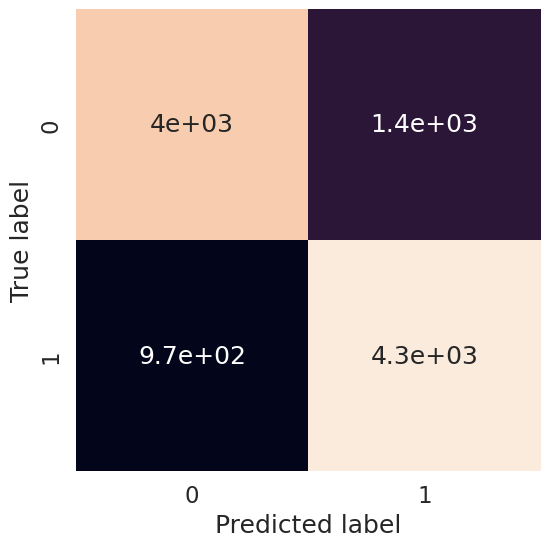

In [110]:
import matplotlib.ticker as ticker
sns.set_theme(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    """
    Plots a nice looking confusion matrix using Seaborn's heatmap().
    """
    matrix = confusion_matrix(y_test, y_preds)
    print(matrix)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax = sns.heatmap(
        matrix,
        annot=True, # Annotate the boxes
        cbar=False
    )
    plt.xlabel("Predicted label") # predictions go on the x-axis
    plt.ylabel("True label") # true labels go on the y-axis 

y_preds = chosen_model.predict(X_test)
plot_conf_mat(y_test, y_preds)

In [38]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       False       0.98      0.00      0.00     47710
        True       0.06      1.00      0.12      3198

    accuracy                           0.06     50908
   macro avg       0.52      0.50      0.06     50908
weighted avg       0.92      0.06      0.01     50908



In [ ]:
X_train

In [ ]:
y_train

In [ ]:
model_scores

In [ ]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar()

In [ ]:
import matplotlib.pyplot as plt

# Feature importance
choosen_model = models['Random Forest']

# Get feature importances
importances = choosen_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

feature_importances = feature_importances[:50]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()